# Learning outcomes
Image segmentation techniques:
1. k-means clustering
2. anisotropic segmentation (produce gradient structure tensor, followeed by thresholding)
3. Watershed segmentation (marker-controlled)

## Setup

In [1]:
!pip install requests

In [2]:
import sys
assert sys.version_info >=(3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## Simple demo of k-means clustering

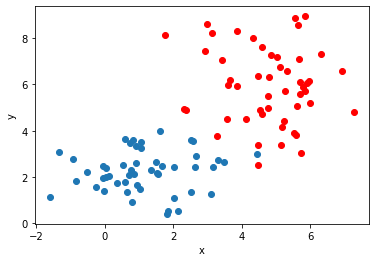

In [3]:
# create first batch pf data
mean1 = (1, 2)
cov1 = np.array([[2, 0], [0, 1]])
dat1 = np.random.multivariate_normal(mean1, cov1, size=50)

# create second batch pf data
mean2 = (5, 6)
cov2 = np.array([[1, 0], [0, 2]])
dat2 = np.random.multivariate_normal(mean2, cov2, size=50)

# concatenate
data = np.vstack((dat1, dat2))
Z = np.float32(data)
# need to in 32float

# visualize
plt.scatter(dat1[:, 0], dat1[:,1])
plt.scatter(dat2[:, 0], dat2[:, 1], c="r")
plt.xlabel("x"), plt.ylabel("y")
plt.show()

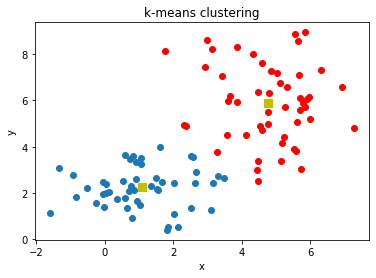

In [4]:
# k-means clustering
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
# ret is WCSOS

#subset the data into clusters defined by k-mean
A = Z[label.flatten() == 0]
B = Z[label.flatten() == 1]

plt.scatter(A[:, 0], A[:, 1] )
plt.scatter(B[:, 0], B[:, 1] , c="r")
plt.scatter(center[:, 0], center[:, 1], c="y", marker="s", s=80)
plt.xlabel("x"), plt.ylabel("y")
plt.title("k-means clustering")
plt.show()

In [5]:
# apply k-means clustering on image
def k_means_clust(img, K, max_iter = 10, eps = 1.0, attempts=10, flag = cv.KMEANS_PP_CENTERS):
    """Args:
    img: 3-channel color image
    K: user defined number of cluster
    By default, max_iter =10, eps=1, attempts=10, kmeans++"""
    #reshape and cast
    img = img.reshape((-1, 3))
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, max_iter, eps)
    return cv.kmeans(img, K, None, criteria, attempts, flag)


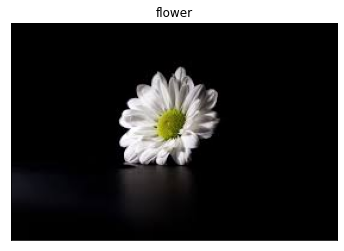

In [6]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt_img(img_rgb, "flower")

In [7]:
# call the function
ret, label, center = k_means_clust(img_rgb, 3)

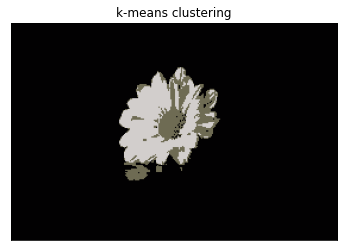

In [8]:
#
center = np.uint8(center)
res = center[label.ravel()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means clustering")

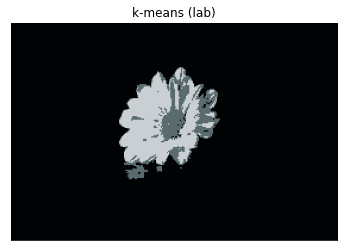

In [9]:
# LAB color space because of perceptual uniformity
img_lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)

ret, label, center = k_means_clust(img_lab, 3)

#
center = np.uint8(center)
res = center[label.ravel()]
quant = res.reshape(img_lab.shape)

quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)
plt_img(quant_rgb, "k-means (lab)")

In [10]:
# interested to know the distribution of clusters 
np.unique(res, axis=0, return_counts=True)

# first row is 45459 of centroid, second is yellow color, third might be white color, yellow and white might be clue to find
# foreground

(array([[  1, 128, 127],
        [112, 122, 124],
        [211, 127, 125]], dtype=uint8),
 array([45433,  1816,  3076], dtype=int64))

In [11]:
#bar plot
centroids, counts = np.unique(res, axis=0, return_counts=True)
#this is in lab

# change centroid to rgb
centroids = centroids.reshape((3, 1, 3))
centroids_rgb = cv.cvtColor(centroids, cv.COLOR_Lab2RGB)
centroids_rgb = centroids_rgb.reshape((3, 3))

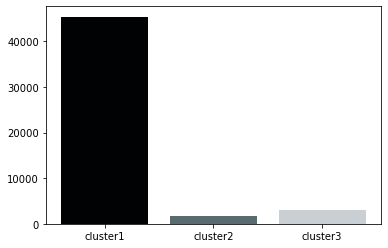

In [12]:
#
xlabel_name = ['cluster' + str(i) for i in range(1, 4)]
plt.bar(xlabel_name, counts, color=list(centroids_rgb / 255))

plt.show()

## Anisotropic segmentation

In [13]:
def calcGST(inputIMG, w, edge_method="scharr"):
    img = np.float32(inputIMG)
    
    # Gradient structure tensor components
    if edge_method=="scharr":
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
    elif elif_method=="sobel":
        imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1)
    else:
        raise Exception("No edge detection method")
        
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)
    
    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    
    return imgCoherencyOut, imgOrientationOut

I had attempted Gaussian filtering, you will run into a numerical statibility problem. 
Ts remedy this problem, add  a small contact on '322 =311 as line 36, line 17-18'

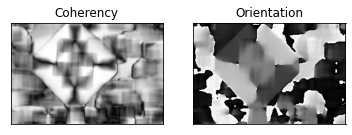

In [14]:
# visualize coherency and orientation
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (7,7), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation =  calcGST(gray, W)

imgCoherency_norm = cv.normalize(imgCoherency, None, alpha=0, beta=1, 
                                 norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
imgOrientation_norm = cv.normalize(imgOrientation, None, alpha=0, beta=1, 
                                 norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
plt.subplot(121), plt_img(imgCoherency_norm, "Coherency")
plt.subplot(122), plt_img(imgOrientation_norm, "Orientation")
plt.show()

In [15]:
# trackbar
def nothing(x):
    pass

wn = "anisotropic segmentation"
cv.namedWindow(wn, cv.WINDOW_NORMAL | cv.WINDOW_FREERATIO)
cv.createTrackbar("Coherency threshold 1", wn, 50, 100, nothing)
cv.createTrackbar("Coherency threshold 2", wn, 70, 100, nothing)
cv.createTrackbar("Orientation threshold 1", wn, 50, 180, nothing)
cv.createTrackbar("Orientation threshold 2", wn, 100, 180, nothing)

#img = cv.imread("images/traffic_sign.jfif")
img = cv.imread("images/road.jpg")
blur = cv.GaussianBlur(img, (7,7), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation = calcGST(gray, W)

while True:
    th_C_1 = cv.getTrackbarPos("Coherency threshold 1", wn) * 0.01
    th_C_2 = cv.getTrackbarPos("Coherency threshold 2", wn) * 0.01
    th_Or_1 = cv.getTrackbarPos("Orientation threshold 1", wn)
    th_Or_2 = cv.getTrackbarPos("Orientation threshold 2", wn)
    
    #perform thresholding
    imgBin_C_1 = cv.threshold(imgCoherency, th_C_1, 255, cv.THRESH_BINARY)[1]
    imgBin_C_2 = cv.threshold(imgCoherency, th_C_2, 255, cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrientation, th_Or_1, 255, cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrientation, th_Or_2, 255, cv.THRESH_BINARY_INV)[1]
    
    imgBin_C = cv.bitwise_and(imgBin_C_1, imgBin_C_2)
    imgBin_Or = cv.bitwise_and(imgBin_Or_1, imgBin_Or_2)
    
    imgBin = cv.bitwise_and(imgBin_C, imgBin_Or)
    
    # mask, elementwise
    mask = imgBin != 0
    res = img*(mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    cv.imshow('segmentation mask', imgBin)
    
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
    
cv.destroyAllWindows()

## watershed segmentation
Topographic surface: edge map <br>
marker: morphological gradient + thresholding

In [16]:
from skimage.segmentation import watershed #watershed
from scipy import ndimage as ndi # connected component labelling

In [17]:
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5,5), 0)
# mean shift segmentation
blur = cv.pyrMeanShiftFiltering(blur, 15, 20, maxLevel=2)

show_img("mean shift", blur)

In [18]:
# change grayscale
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# morphological gradient (structuring element)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
loc_grad = cv.morphologyEx(gray, cv.MORPH_GRADIENT, kernel, iterations=2)

show_img("gradient", loc_grad)

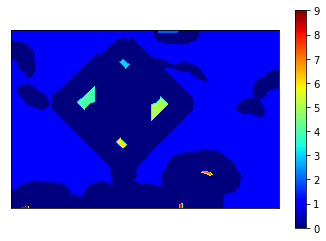

In [19]:
# thresholding
th = loc_grad < 80 #binary image
#connectivity
s = np.ones((3,3), dtype=int)
marker = ndi.label(th, structure=s)[0]

plt.imshow(marker, cmap=plt.cm.jet)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

In [20]:
## topographic surface
edge = cv.Canny(gray, 250, 500)
labels = watershed(edge, marker)

In [21]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

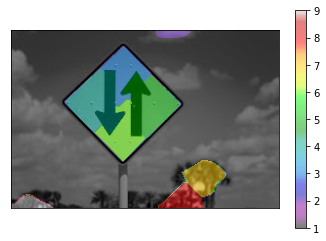

In [22]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap="gray")
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

In [23]:
# create a white mask, suppress the pixel of background to 0, find contour
mask = 255 * np.ones(labels.shape, dtype=np.uint8)

# assumption: background has the largest area
label_vec, counts = np.unique(labels, return_counts=True)
label_bg = label_vec[np.argmax(counts)]

mask[labels == label_bg] = 0

# find contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# grab the largest area contour
contour = sorted(contours, key=cv.contourArea, reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0,255,0), 2)

show_img("contour", img_copy)

In [24]:
x, y, w, h = cv.boundingRect(contour)
img = cv.imread("images/traffic_sign.jfif")
cv.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
show_img("bounding box", img)

## watershed example
Topographic surface: - distance transform <br>
marker: thresholding + distance transform

In [25]:
# another traffic sign image
img = cv.imread("images/traffic_sign1.jpg")

show_img("img", img)

In [26]:
#blurring
blur = cv.GaussianBlur(img, (5, 5), 0)

#convert to Lab
img_lab = cv.cvtColor(blur, cv.COLOR_BGR2Lab)

# k-means clustering
ret, label, center = k_means_clust(img_lab, 10)

# reshape
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_lab.shape)

quant_bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)

show_img("k-means lab", quant_bgr)

In [27]:
#grayscale
gray = cv.cvtColor(quant_bgr, cv.COLOR_BGR2GRAY)

#otsu threholding
th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

# morphological opening
kernel = np.ones((3,3 ), dtype=np.uint8)
th = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=3)

show_img("th", th)

In [28]:
from skimage.feature import peak_local_max

In [29]:
# distance transform
dist_transform = cv.distanceTransform(th, cv.DIST_L2, 3)

# mask
mask = np.zeros(dist_transform.shape, dtype=bool)
coords = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=th)

mask[tuple(coords.T)] = True
marker = ndi.label(mask)[0]

#watershed
labels = watershed(-dist_transform, marker, mask=th)

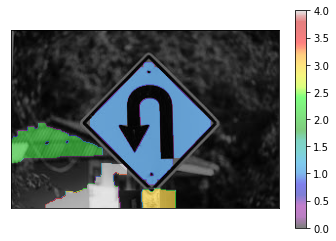

In [30]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap="gray")
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

In [31]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4]),
 array([39209,  6387,  2276,   646,  1807], dtype=int64))

In [32]:
# create a white mask, suppress the pixel of background to 0, find contour
mask = 255 * np.ones(labels.shape, dtype=np.uint8)

# assumption: background has the largest area
label_vec, counts = np.unique(labels, return_counts=True)
label_bg = label_vec[np.argmax(counts)]

mask[labels == label_bg] = 0

# find contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# grab the largest area contour
contour = sorted(contours, key=cv.contourArea, reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0,255,0), 2)

show_img("contour", img_copy)

In [33]:
x, y, w, h = cv.boundingRect(contour)
img_copy = img.copy()
cv.rectangle(img_copy, (x, y), (x+w, y+h), (0,255,0), 2)
show_img("bounding box", img_copy)

## Weekly activity

In [34]:
from sklearn.cluster import KMeans


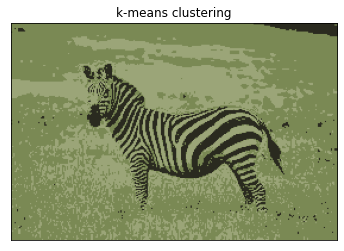

In [35]:
img = cv.imread("images/zebra.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# plt_img(img_rgb, "zebra")
ret, label, center = k_means_clust(img_rgb, 3)
center = np.uint8(center)
res = center[label.ravel()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means clustering")

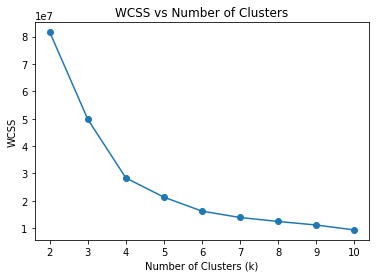

In [36]:
# img = cv.imread("images/zebra.jfif")
# show_img("zebra", img)
img = cv.imread("images/zebra.jfif")
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

#reshape and cast
img = img.reshape(-1,3)
img = np.float32(img)

# Determine optimal k using WCSS
wcsos = []
for k in range(2, 11):
    ret, label, center = cv.kmeans(img, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    wcsos.append(ret)

# Plot WCSS vs Number of Clusters
plt.plot(range(2, 11), wcsos, marker='o')
plt.title('WCSS vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()
# show_img("hi", img_rgb)

In [37]:
img_rgb.shape

(183, 275, 3)

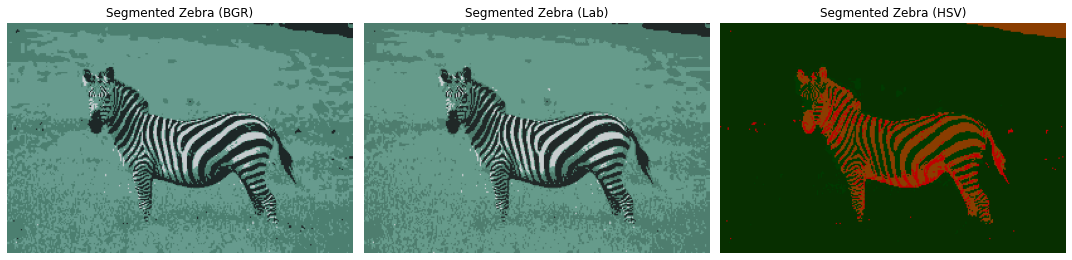

In [38]:
##### Load the image
img = cv.imread("images/zebra.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Define the optimal k value
optimal_k = 4

# List of color spaces to iterate over
color_spaces = ['BGR', 'Lab', 'HSV']

plt.figure(figsize=(15, 5))

# Iterate over the color spaces
for color_space in color_spaces:
    # Convert the image to the selected color space
    if color_space == 'BGR':
        img_space = img
    elif color_space == 'Lab':
        img_space = cv.cvtColor(img, cv.COLOR_BGR2Lab)
    elif color_space == 'HSV':
        img_space = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    # Reshape and convert to float32
    img_space = img_space.reshape((-1, 3))
    img_space = np.float32(img_space)
    
    # Perform K-means clustering
    ret, label, center = cv.kmeans(img_space, optimal_k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.ravel()]
    quant = res.reshape(img_space.shape)
    
    # Convert back to original color space for display
    if color_space == 'BGR':
        quant_display = quant.reshape(img.shape)
    else:
        quant_display = cv.cvtColor(quant.reshape(img.shape), cv.COLOR_Lab2BGR)
    
    # Plot the segmented image
    plt.subplot(1, 3, color_spaces.index(color_space) + 1)
    plt.imshow(quant_display)
    plt.title(f'Segmented Zebra ({color_space})')
    plt.axis('off')

# Show the plotted images
plt.tight_layout()
plt.show()

- BGR
- the segmented zebra is clear, but do not exclude the complex background

- Lab
- the segmented zebra is clear, same as result of BGR, but clearer in the background

- HSV
- the segmented zebra is clear, based on the clor and brightness information, the background background of green field is excluded